# Kopiert  Zisterne Datenfiles in XLS File


### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import requests
from IPython.display import IFrame
import datetime
import re
from sklearn import tree
import mysql.connector as mariadb

## Daten einlesen und Rohdaten in EXCEL Tabelle speichern

In [2]:
# Datensammlung einlesen
df1=pd.read_csv('Datensammlung.csv',engine='python',sep=';',decimal=',',index_col=False)
df1['Timestamp']=pd.to_datetime(df1['Date'],format='%d.%m.%Y %H:%M')
#Umbenennung falsche Spaltennamen
df1=df1.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
df1.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
629,181203_V310_4.csv,03.12.2018 16:17,1097,3446,98,Kein Fehler erkannt,1.51,180,14.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03 16:17:00
630,181203_V310_4.csv,03.12.2018 17:17,1136,3568,100,Kein Fehler erkannt,0.00,180,16.23,0.0,122.0,156.0,21.0,Verstopft,NaN,NaN,2018-12-03 17:17:00
631,181203_V310_4.csv,03.12.2018 18:17,1221,3835,98,Kein Fehler erkannt,1.81,180,18.00,0.0,267.0,157.0,0.0,OK,NaN,NaN,2018-12-03 18:17:00
632,181203_V310_4.csv,03.12.2018 19:17,1330,4178,100,Kein Fehler erkannt,0.00,180,20.65,0.0,343.0,244.0,0.0,OK,NaN,NaN,2018-12-03 19:17:00
633,181203_V310_4.csv,03.12.2018 20:17,1437,4514,100,Kein Fehler erkannt,0.00,180,22.72,0.0,336.0,186.0,0.0,OK,NaN,NaN,2018-12-03 20:17:00


### Weitere Daten lesen ab 3.12.18
Alle Daten befinden sich im unterverzeichnis ./csv. Die obigen Daten stehen im ./bak verzeichnis

In [3]:
# Aktuelle Web-Page darstellen 
IFrame(src='http://192.168.178.5', width=700, height=800)

Erst mal neue Daten lesen

In [4]:
# Programm Version bestimmen 
#<H2>Programminfo</h2><p>V3.1.0</p>
response = requests.get('http://192.168.178.5')
base_text = response.text
base_text=base_text.replace('\n','')
base_text=base_text.replace('\r','')
#x = re.match('.*<H2>Programminfo</h2><p>(\S*)</p>.*', base_text) 
x = re.search('(?<=<H2>Programminfo</h2><p>)(\S+)(?=</p>)', base_text) 
version=x.group(0)
version=version.replace('.','')

# Get data log file
response = requests.get('http://192.168.178.5/Res_Ctl.csv')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="csv/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".csv"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")
    
# Get system log file
response = requests.get('http://192.168.178.5/Res_Ctl.log')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="log/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".log"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")    

    

New file saved: csv/200724155612_V423.csv
New file saved: log/200724160126_V423.log


In [5]:
# Dateien listen
newfiles=os.listdir('./csv')
#newfiles

In [6]:
#Dataframe mit allen Daten erstellen
df=df1
for nFile in newfiles:
    df2=pd.read_csv('./csv/'+nFile,engine='python',sep=';',decimal='.',index_col=False)    
    df2=df2.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]", "Refill quantity 24h [Liter]":"Refill quantity 1h [Liter]"})
    df2.insert(0,'Log File',nFile)
    df2['Timestamp']=pd.to_datetime(df2['Date'],format='%Y-%m-%d %H:%M:%S')
    df=df.append(df2,sort=False)
df.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
1154,200724155612_V423.csv,2020-07-24 11:23:17,484,1520,100,Kein Fehler erkannt,0.00,9100,482.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-24 11:23:17
1155,200724155612_V423.csv,2020-07-24 12:23:25,483,1517,100,Kein Fehler erkannt,0.00,9100,482.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-24 12:23:25
1156,200724155612_V423.csv,2020-07-24 13:23:34,482,1514,98,Kein Fehler erkannt,1.09,9100,482.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-24 13:23:34
1157,200724155612_V423.csv,2020-07-24 14:23:41,480,1507,100,Kein Fehler erkannt,0.00,9100,482.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-24 14:23:41
1158,200724155612_V423.csv,2020-07-24 15:23:50,464,1457,100,Kein Fehler erkannt,0.00,9100,482.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-24 15:23:50


In [7]:
df.describe()

,Level [mm],Quantity [Liter],Signal health [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 1h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Usage in last 24h [Liter],Usage average in last 10d [Liter]
count,14954.000000,14954.000000,14954.000000,14954.000000,14954.000000,14479.000000,213.000000,213.000000,213.000000,213.000000,68.000000,68.000000
mean,1136.247760,3569.140765,98.368731,1.202946,4597.699612,232.102373,1.690141,150.910798,206.816901,27.389671,135.058824,129.000000
std,606.975478,1906.876233,4.798465,7.556553,2890.858165,231.456315,18.144019,105.886939,131.340151,34.257671,128.314083,93.518934
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-198.000000,89.000000,0.000000,-36.000000,18.000000
25%,502.000000,1577.000000,98.000000,0.000000,740.000000,4.430000,0.000000,88.000000,119.000000,0.000000,47.250000,65.000000
50%,1314.000000,4127.500000,99.000000,0.440000,5960.000000,177.000000,0.000000,128.000000,159.000000,10.000000,83.500000,84.500000
75%,1720.000000,5403.000000,100.000000,1.490000,6060.000000,383.200000,0.000000,201.000000,249.000000,53.000000,241.500000,180.000000
max,1885.000000,5921.000000,100.000000,895.120000,9100.000000,752.300000,260.000000,582.000000,853.000000,224.000000,445.000000,330.000000


In [8]:
# Rohdaten abspeichern als xls
df.to_excel('../log/data_collection_raw.xlsx')

## Vorverarbeitung

In [9]:
# Daten mit 1.1.70 entfernen (Daten die nach Neustart vor NTP Update eingetragen wurden)
df=df[(df['Timestamp']>'1970-01-01 12:00:00')]

# Datum als Index setzen
df.set_index('Timestamp',inplace=True,drop=False)


In [10]:
# Replace Rain quantity 24h from 1.5.19 (Homematic IP delivers total rain counter instead of 24h value)
dt=df['Timestamp'].astype('int64').diff(24)/(1e9*60*60*24)
df["Rain quantity total [Liter]"]=df["Rain quantity 24h [Liter]"];

# Leere Zellen in Nan umwandeln und Nan interpolieren
df["Rain quantity 24h [Liter]"]=df["Rain quantity total [Liter]"].replace(-1, np.nan)
df["Rain quantity 24h [Liter]"]=df["Rain quantity 24h [Liter]"].replace(r'^\s+$', np.nan, regex=True)

# NaNs Interpolieren
df["Rain quantity 24h [Liter]"]=df["Rain quantity 24h [Liter]"].interpolate()

# Ableitung der kummulierten Daten
df["Rain quantity 24h [Liter]"].where((df['Timestamp']<'2019-04-26 23:35:38'),df["Rain quantity 24h [Liter]"].diff(24)/dt,True);

# Sonderbehandlung zweier Werte nach längerer Ausfallzeit
df["Rain quantity 24h [Liter]"].where((df['Timestamp']>'2019-08-12 09:06:08') | (df['Timestamp']<'2019-08-12 08:05:59'),0,True);




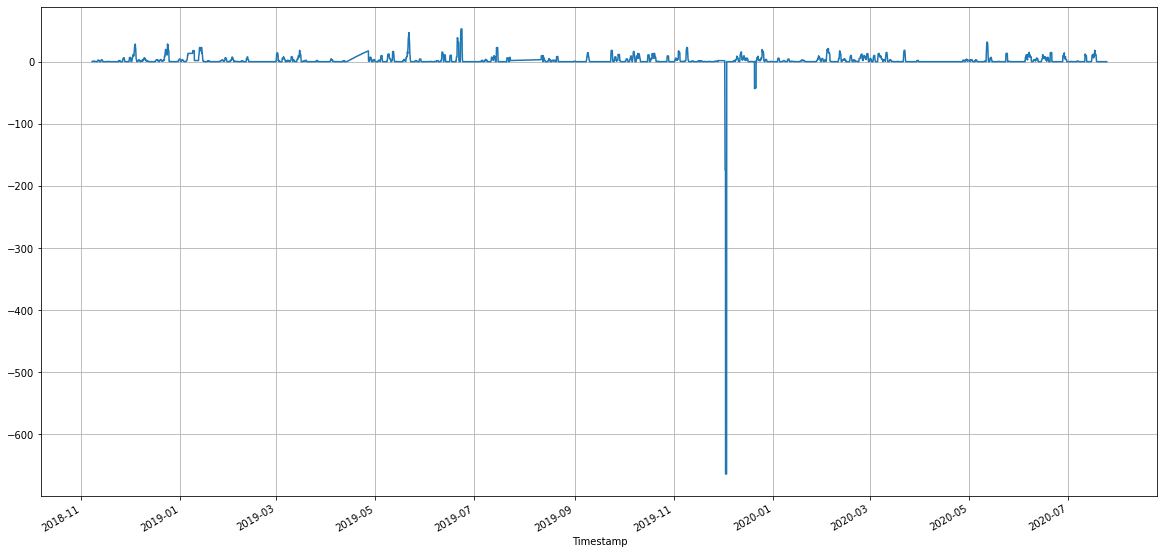

In [11]:
plt.figure(figsize=(20,10))

df["Rain quantity 24h [Liter]"] .plot()
plt.grid()


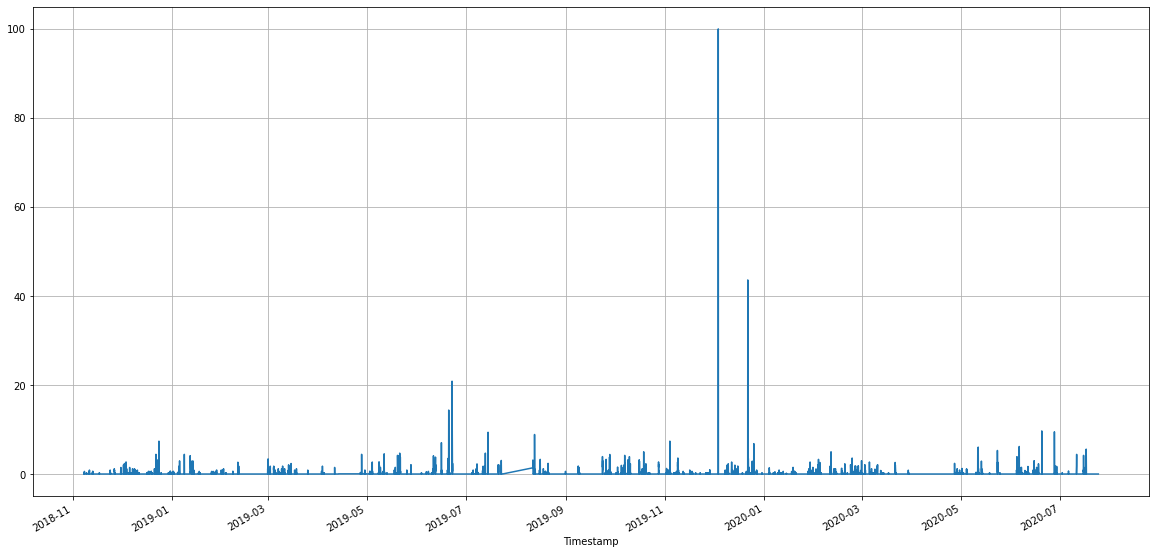

In [12]:
# Einstündige Regenmengen berechnen
df['Rain quantity 1h [Liter]']=df['Rain quantity 24h [Liter]'].diff()
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].clip(0,100)

# Kontrollplot
plt.figure(figsize=(20,10))
df['Rain quantity 1h [Liter]'].plot()
plt.grid()

In [13]:
#Korrigierte Daten abspeichern als xls
df.to_excel('../log/data_collection.xlsx')